# Description

Explore research backtest results.

**Note**: use `dataflow/model/notebooks/Master_backtest_analysis_param_sweep.ipynb` for standard backtest analysis.
This notebook is used for free-form analysis and hypotheses testing, and thus is not as strictly maintained.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
import os

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint
import oms.broker.ccxt.ccxt_utils as obccccut

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-8debe1e4-7037-485a-819c-4695566df9f2.json'
INFO  # Git
  branch_name='master'
  hash='b31fd18ee'
  # Last commits:
    * b31fd18ee Nina Lee Cm task7579 Support multiple configs for a single model (#7770)   (68 minutes ago) Tue May 7 19:27:38 2024  (HEAD -> master, origin/master, origin/HEAD)
    * eb1d1ed91 Toma Jordania CmTask8033: update Master_trading_system_report notebook - load balances in separate function (#8187) (   3 hours ago) Tue May 7 17:51:04 2024           
    * b9ffbbd28 Juraj Smeriga CmampTask8154_Add_document_about_CloudWatch (#8213)               (   4 hours ago) Tue May 7 17:04:44 2024           
# Machine info
  system=Linux
  node name=165311e39b41
  release=5.15.0-1056-aws
  version=#61~20.04.1-Ubuntu SMP Wed Mar 13 17:40:41 UTC 2024
  machine=x86_64
  processor=x86_64
  cpu count=8
  cpu freq=scpufreq(current=2499.9959999999996, min=0.0, max=0.0)
  

# Build the config dict

In [4]:
# Get config from env when running the notebook via the `run_notebook.py` script.
default_config = cconfig.get_config_from_env()
if default_config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Build default config.
    #amp_dir = hgit.get_amp_abs_path()
    dir_name = "/shared_data/model/historical/build_tile_configs.C11a.ccxt_v8_1-all.5T.2024-04-01_2024-05-31.ins.run0/tiled_results"
    # Create a subfolder to store portfolio metrics.
    # The subfolder is marked by the datetime of the run, e.g.
    # "build_tile_configs.C11a.ccxt_v8_1-all.5T.2023-01-01_2024-03-20.ins.run0/portfolio_dfs/20240326_131724".
    # TODO(Danya): Factor out into a function.
    default_config_dict = {
        "dir_name": dir_name,
        "start_date": datetime.date(2024, 4, 1),
        "end_date": datetime.date(2024, 5, 31),
        "asset_id_col": "asset_id",
        "pnl_resampling_frequency": "H",
        "rule": "5T",
        "im_client_config": {
            "vendor": "ccxt",
            "universe_version": "v8.1",
            "root_dir": "s3://cryptokaizen-data.preprod/v3",
            "partition_mode": "by_year_month",
            "dataset": "ohlcv",
            "contract_type": "futures",
            "data_snapshot": "",
            "aws_profile": "ck",
            "version": "v1_0_0",
            "download_universe_version": "v8",
            "tag": "downloaded_1min",
            "download_mode": "periodic_daily",
            "downloading_entity": "airflow",
            "resample_1min": False,
        },
        "annotate_forecasts_kwargs": {
            "quantization": 30,
            "liquidate_at_end_of_day": False,
            "initialize_beginning_of_day_trades_to_zero": False,
            "burn_in_bars": 3,
            "compute_extended_stats": True,
        },
        "forecast_evaluator_kwargs": {
            "price_col": "open",
            "volatility_col": "garman_klass_vol",
            "prediction_col": "feature",
            "optimizer_config_dict": {
                "dollar_neutrality_penalty": 0.0,
                "constant_correlation": 0.5,
                "constant_correlation_penalty": 50.0,
                "relative_holding_penalty": 0.0,
                "relative_holding_max_frac_of_gmv": 0.1,
                "target_gmv": 1000.0,
                "target_gmv_upper_bound_penalty": 0.0,
                "target_gmv_hard_upper_bound_multiple": 1.05,
                "transaction_cost_penalty": 0.5,
                "solver": "ECOS",
                "verbose": False,
            },
        },
        "bin_annotated_portfolio_df_kwargs": {
            "proportion_of_data_per_bin": 0.2,
            "normalize_prediction_col_values": False,
        },
        "load_all_tiles_in_memory": True,
        "sweep_param": {
            "keys": (
                "column_names",
                "price_col",
            ),
            "values": [
                "open",
            ],
        },
    }
    # Add asset_id_to_share_decimals based on the `quantization` parameter.
    if not default_config_dict["annotate_forecasts_kwargs"]["quantization"]:
        asset_id_to_share_decimals = obccccut.get_asset_id_to_share_decimals(
            "amount_precision"
        )
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = asset_id_to_share_decimals
    else:
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = None
    # Build config from dict.
    default_config = cconfig.Config().from_dict(default_config_dict)
print(default_config)

INFO  Using hardwired config
dir_name: /app/build_tile_configs.C11a.ccxt_v8_1-all.5T.2024-04-01_2024-05-31.ins.run0/tiled_results
start_date: 2024-04-01
end_date: 2024-05-31
asset_id_col: asset_id
pnl_resampling_frequency: H
rule: 5T
im_client_config: 
  vendor: ccxt
  universe_version: v8.1
  root_dir: s3://cryptokaizen-data.preprod/v3
  partition_mode: by_year_month
  dataset: ohlcv
  contract_type: futures
  data_snapshot: 
  aws_profile: ck
  version: v1_0_0
  download_universe_version: v8
  tag: downloaded_1min
  download_mode: periodic_daily
  downloading_entity: airflow
  resample_1min: False
annotate_forecasts_kwargs: 
  quantization: 30
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  burn_in_bars: 3
  compute_extended_stats: True
  asset_id_to_share_decimals: None
forecast_evaluator_kwargs: 
  price_col: open
  volatility_col: garman_klass_vol
  prediction_col: feature
  optimizer_config_dict: 
    dollar_neutrality_penalty: 0.0
    const

# Load tiled results

## Report tile stats

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    default_config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1020313424,1,2,2,7.3 MB
1106736216,1,2,2,7.4 MB
1669260535,1,2,2,7.4 MB
1670436375,1,2,2,7.3 MB
1775391824,1,2,2,7.3 MB
1813442534,1,2,2,7.4 MB
1871387621,1,2,2,7.2 MB
2200033667,1,2,2,7.3 MB
2237530510,1,2,2,7.2 MB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids      size
year month                       
2024 4               25  151.6 MB
     5               25   31.2 MB

In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1020313424,
 1106736216,
 1669260535,
 1670436375,
 1775391824,
 1813442534,
 1871387621,
 2200033667,
 2237530510,
 2470395105,
 2499295598,
 2506553600,
 2565005155,
 2601760471,
 2971863517,
 2989693852,
 3304664847,
 3323452427,
 3326458212,
 4417972573,
 5141755262,
 6009830573,
 6335759645,
 8717633868,
 8968126878]

## Load tile data

In [9]:
if default_config["load_all_tiles_in_memory"]:
    asset_ids_to_load = asset_ids
else:
    asset_ids_to_load = asset_ids[0:1]
asset_batch_size = len(asset_ids_to_load)
cols = None
#
asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        default_config["dir_name"],
        asset_ids_to_load,
        default_config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
tile_df = dtfmod.process_parquet_read_df(
    asset_tile, default_config["asset_id_col"]
)

In [11]:
tile_df.columns.levels[0].to_list()

['close',
 'close_mean',
 'feature',
 'garman_klass_vol',
 'high',
 'low',
 'month',
 'open',
 'p1',
 'p1.c',
 'p1.c.xs_adj',
 'p1.c.xs_adj.c',
 'p2',
 'p2.c',
 'p2.c.xs_adj',
 'p2.c.xs_adj.c',
 'p3',
 'p_diff',
 'p_diff.c',
 'p_diff.c.xs_adj',
 'p_diff.c.xs_adj.c',
 'p_est_mean',
 'p_lr',
 'p_lr.c',
 'p_lr.c.xs_adj',
 'p_lr.c.xs_adj.c',
 'q1',
 'q1.c',
 'q1.c.xs_adj',
 'q1.c.xs_adj.c',
 'q2',
 'q2.c',
 'q2.c.xs_adj',
 'q2.c.xs_adj.c',
 'q3',
 'q3.c',
 'q3.c.xs_adj',
 'q3.c.xs_adj.c',
 'q4',
 'q5',
 'q6',
 'q_mv',
 'q_mv_adj',
 'q_mv_os',
 'r1',
 'r1.c',
 'r1.c.xs_adj',
 'r1.c.xs_adj.c',
 'r2',
 'r2.c',
 'r2.c.xs_adj',
 'r2.c.xs_adj.c',
 'r3',
 'r4',
 'r4.c',
 'r4.c.xs_adj',
 'r4.c.xs_adj.c',
 'r5',
 'r5.c',
 'r5.c.xs_adj',
 'r5.c.xs_adj.c',
 'r6',
 'r6.c',
 'r6.c.xs_adj',
 'r6.c.xs_adj.c',
 'r_est',
 'r_est.c',
 'r_est.c.xs_adj',
 'r_est.c.xs_adj.c',
 'r_lr',
 'r_lr.c',
 'r_lr.c.xs_adj',
 'r_lr.c.xs_adj.c',
 'sqrt_q_mv',
 'sqrt_q_mv_adj',
 'sqrt_q_mv_os',
 'v_ld',
 'v_ld.c',
 'v_ld.c.

In [12]:
tile_df.head(3)

close                                                                                                                                                                                                                                                                         close_mean                                                                                                                                                                                                                                                                            feature                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                           \
asset_id                  1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878       1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2024-04-01 00:00:00+00:00     3.6927     3.0468    10.6602     22.435     1.2407    0.39304     3930.3     96.288    202.678     128.45    0.15902     36.833     3.6606     19.193     3.6909     5.5115     679.58     34.314     1.9157     2.9673     1.6639     8.2300     18.801     54.134     606.03    3.69264    3.04818   10.66358    22.4604    1.24056   0.393076    3938.38    96.3400   202.9346    128.480   0.158972    36.8510    3.67048    19.1754    3.68982    5.50532    680.812    34.3342    1.91708    2.96846    1.66520    8.23122    18.7970    54.1558    606.158   0.091039   0.764817   0.046444   1.017113  -0.985573  -1.373699   0.411046  -0.011488   0.711988   0.027382   0.147041   0.149588   0.623767  -2.100717  -1.323650  -0.697645   1.701121   0.561439   0.797086  -1.057546   0.251403   0.174468   0.292536   0.032735  -0.162816         0.000809   0.001086   0.001185   0.001610   0.000654   0.001254   0.002882   0.001090   0.002484   0.001390   0.000882   0.000898   
2024-04-01 00:05:00+00:00     3.6892     3.0395    10.6965     

# Compute and save portfolio bar metrics

In [13]:
# Get configs sweeping over parameter.
config_dict = dtfmod.build_research_backtest_analyzer_config_sweep(default_config)
print(config_dict.keys())

dict_keys(['column_names:price_col = open'])


In [14]:
import optimizer.forecast_evaluator_with_optimizer as ofevwiop


portfolio_df_dict = {}
bar_metrics_dict = {}
for key, config in config_dict.items():
    if config["load_all_tiles_in_memory"]:
        fep = ofevwiop.ForecastEvaluatorWithOptimizer(
            **config["forecast_evaluator_kwargs"].to_dict(),
        )
        portfolio_df, bar_metrics = fep.annotate_forecasts(
            tile_df,
            **config["annotate_forecasts_kwargs"].to_dict(),
        )
    else:
        portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
            config["dir_name"],
            config["start_date"],
            config["end_date"],
            config["asset_id_col"],
            config["forecast_evaluator_kwargs"]["price_col"],
            config["forecast_evaluator_kwargs"]["volatility_col"],
            config["forecast_evaluator_kwargs"]["prediction_col"],
            asset_ids=None,
            annotate_forecasts_kwargs=config[
                "annotate_forecasts_kwargs"
            ].to_dict(),
            return_portfolio_df=True,
        )
    portfolio_df_dict[key] = portfolio_df
    bar_metrics_dict[key] = bar_metrics
portfolio_stats_df = pd.concat(bar_metrics_dict, axis=1)

  0%|          | 0/10369 [00:00<?, ?it/s]

In [31]:
portfolio_stats_df

,pnl,gross_volume,net_volume,gmv,nmv,gpc,npc,wnl
2024-04-01 00:15:00+00:00,1.642920,1367.283279,-393.501554,1050.057546,-268.047864,25.0,-3.0,5.0
2024-04-01 00:20:00+00:00,1.637539,1594.728812,364.499425,1049.152354,98.089100,25.0,7.0,5.0
2024-04-01 00:25:00+00:00,0.917359,1098.165683,-223.496812,1052.681257,-124.490353,25.0,1.0,9.0
2024-04-01 00:30:00+00:00,-0.677401,791.701886,300.468633,1049.180553,175.300878,25.0,-3.0,-11.0
2024-04-01 00:35:00+00:00,-0.329555,1219.361223,-103.758565,1048.261225,71.212758,25.0,-5.0,2.0
...,...,...,...,...,...,...,...,...
2024-05-06 23:40:00+00:00,-0.686680,691.323426,81.527417,1049.013483,256.907412,25.0,7.0,-9.0
2024-05-06 23:45:00+00:00,-0.182921,858.692867,-176.151338,1047.378102,80.573153,25.0,7.0,-5.0
2024-05-06 23:50:00+00:00,0.149567,1153.438288,-105.398170,1050.757512,-24.675451,25.0,3.0,4.0
2024-05-06 23:55:00+00:00,-0.378940,916.368353,20.066424,1050.572322,-4.987967,25.0,3.0,5.0


In [ ]:
# Drop level with the col_name label so that we remove the label from the plots.
portfolio_stats_df = portfolio_stats_df.droplevel(0, axis=1)

In [41]:
# Keep only the last month only.
portfolio_stats_df_timestamped = portfolio_stats_df.loc["2024-04-07 00:00:00+00:00":]

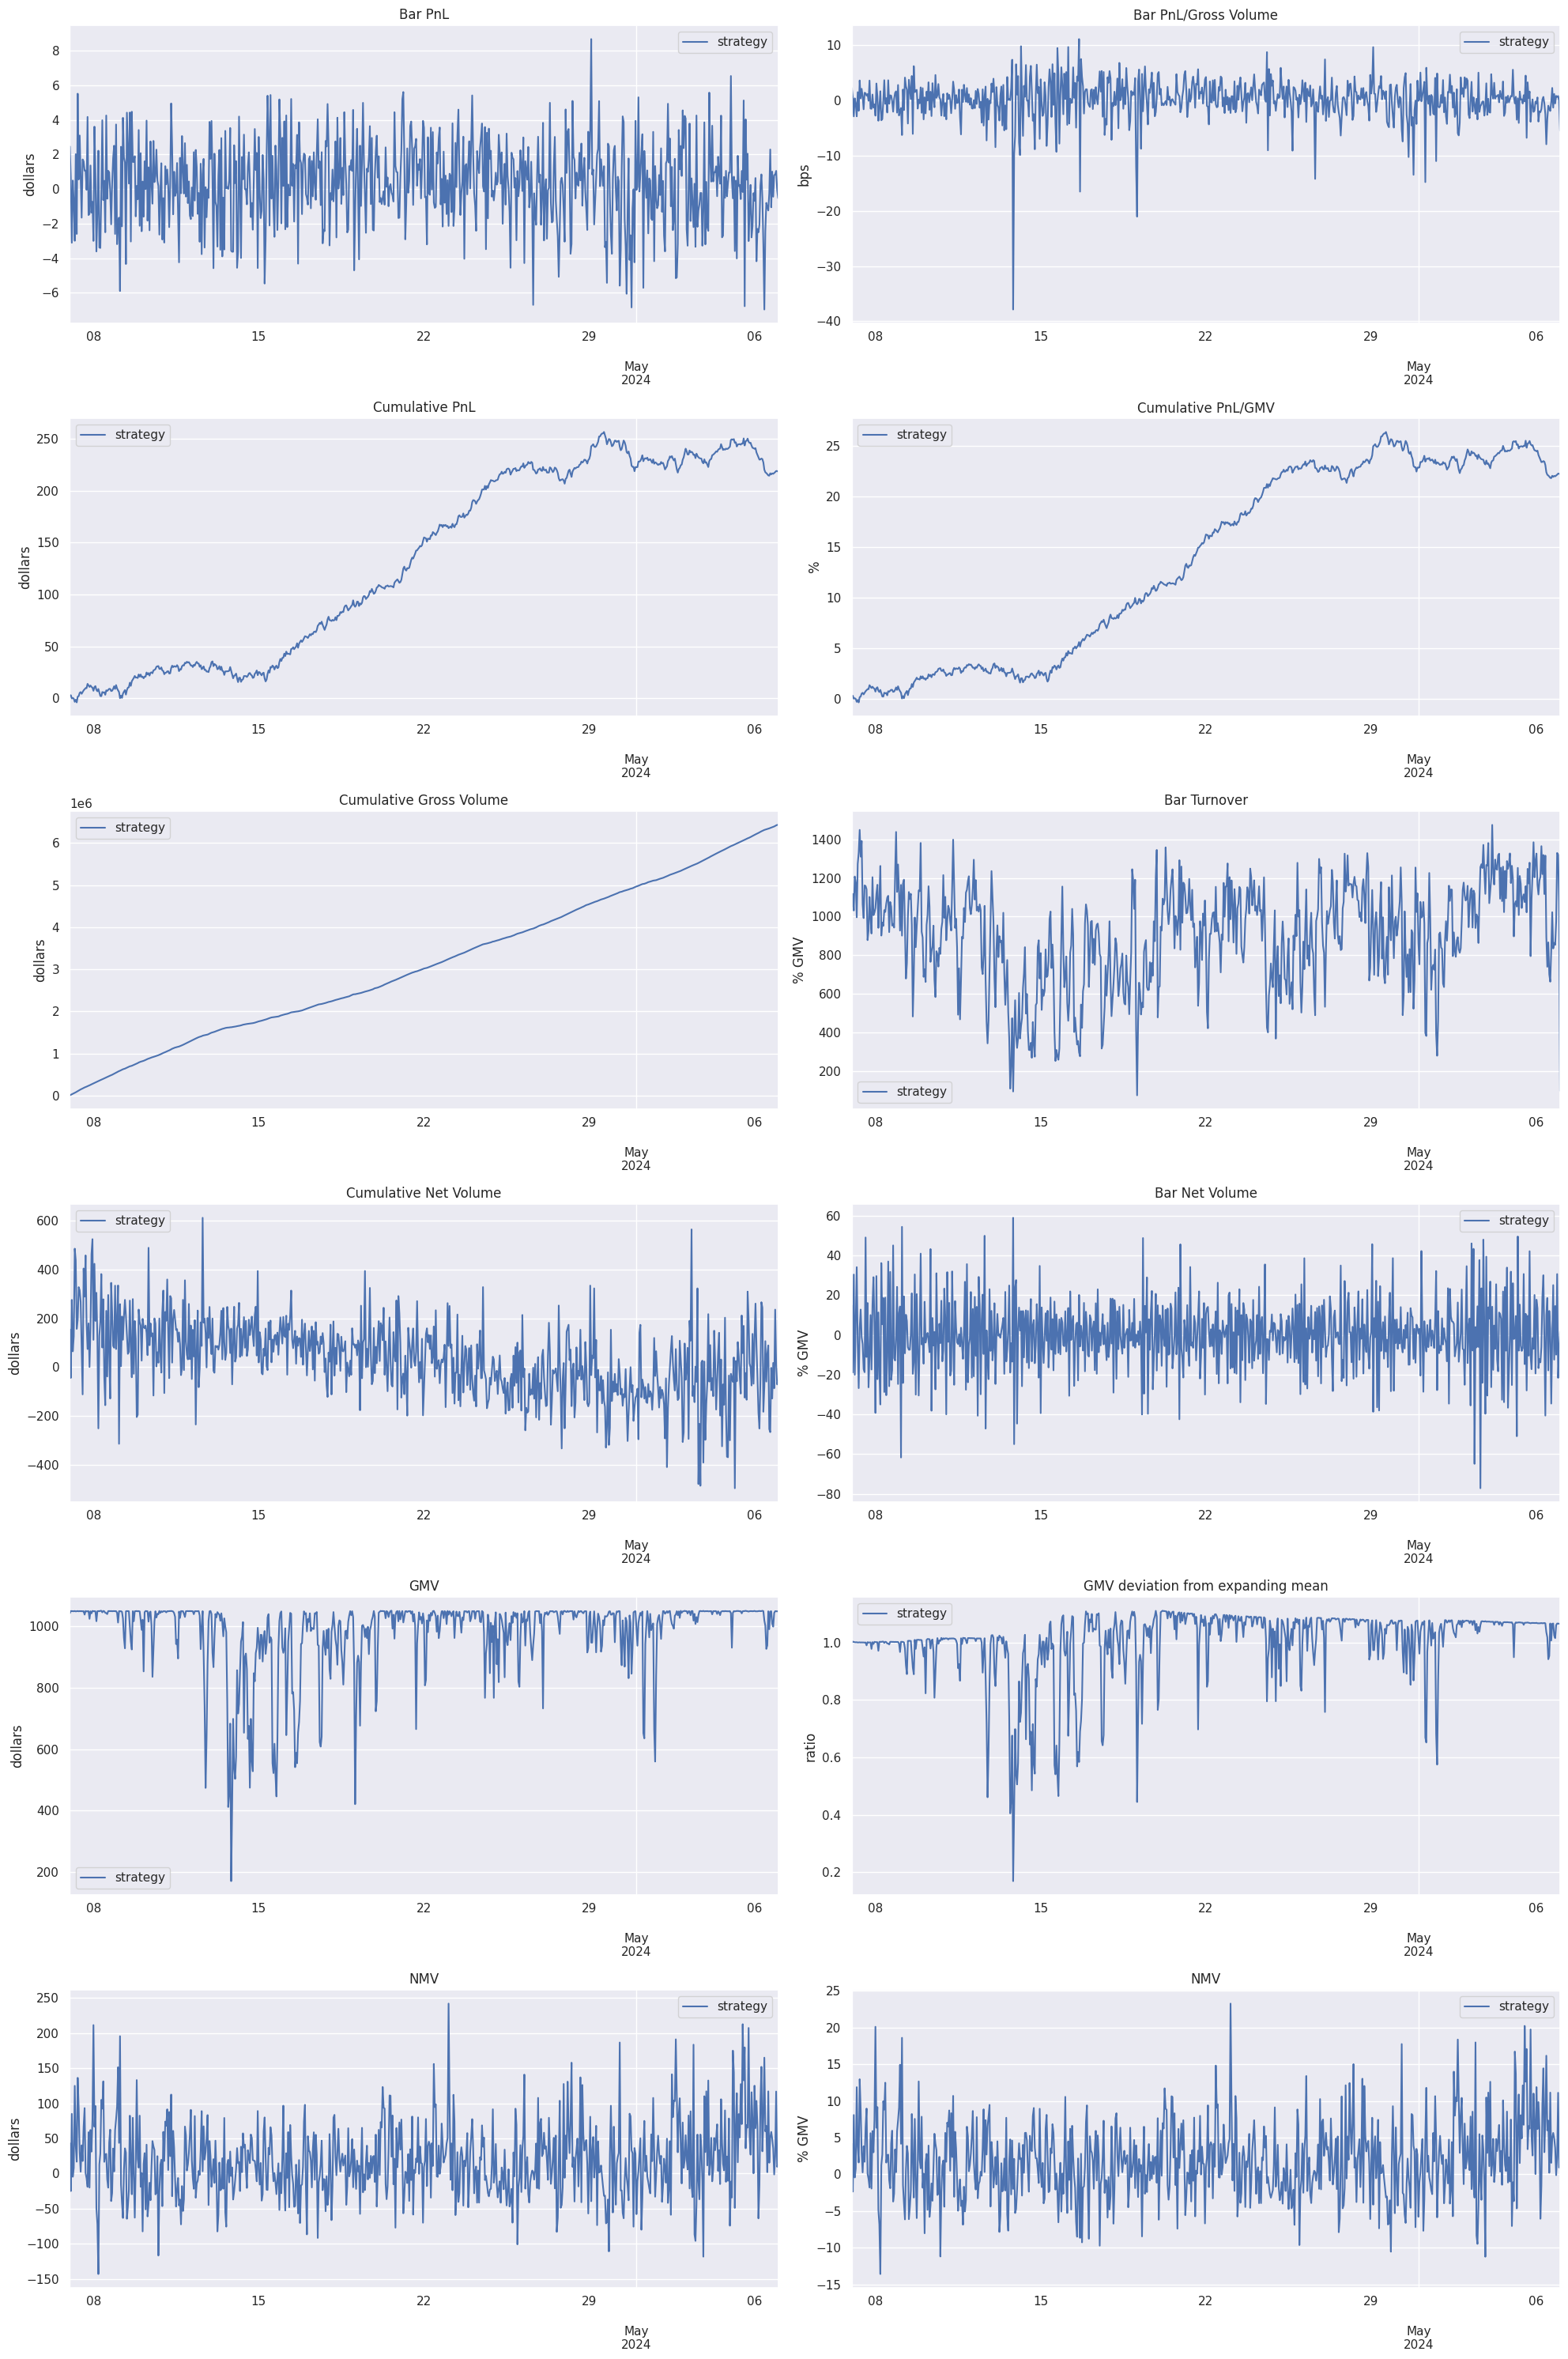

In [42]:
coplotti.plot_portfolio_stats(
    portfolio_stats_df_timestamped, freq=default_config["pnl_resampling_frequency"]
)

,pnl,pnl_in_bps,sgn_corr,corr
prediction,,,,
"(-inf, -0.842]",0.002746,0.165726,0.027501,0.021895
"(-0.842, -0.253]",0.001651,0.438426,0.013556,0.009790
"(-0.253, 0.253]",-0.000447,-0.140460,-0.000295,-0.003221
"(0.253, 0.842]",-0.000088,-0.092750,-0.000464,-0.001190
"(0.842, inf]",0.001634,0.164248,-0.003846,0.008977


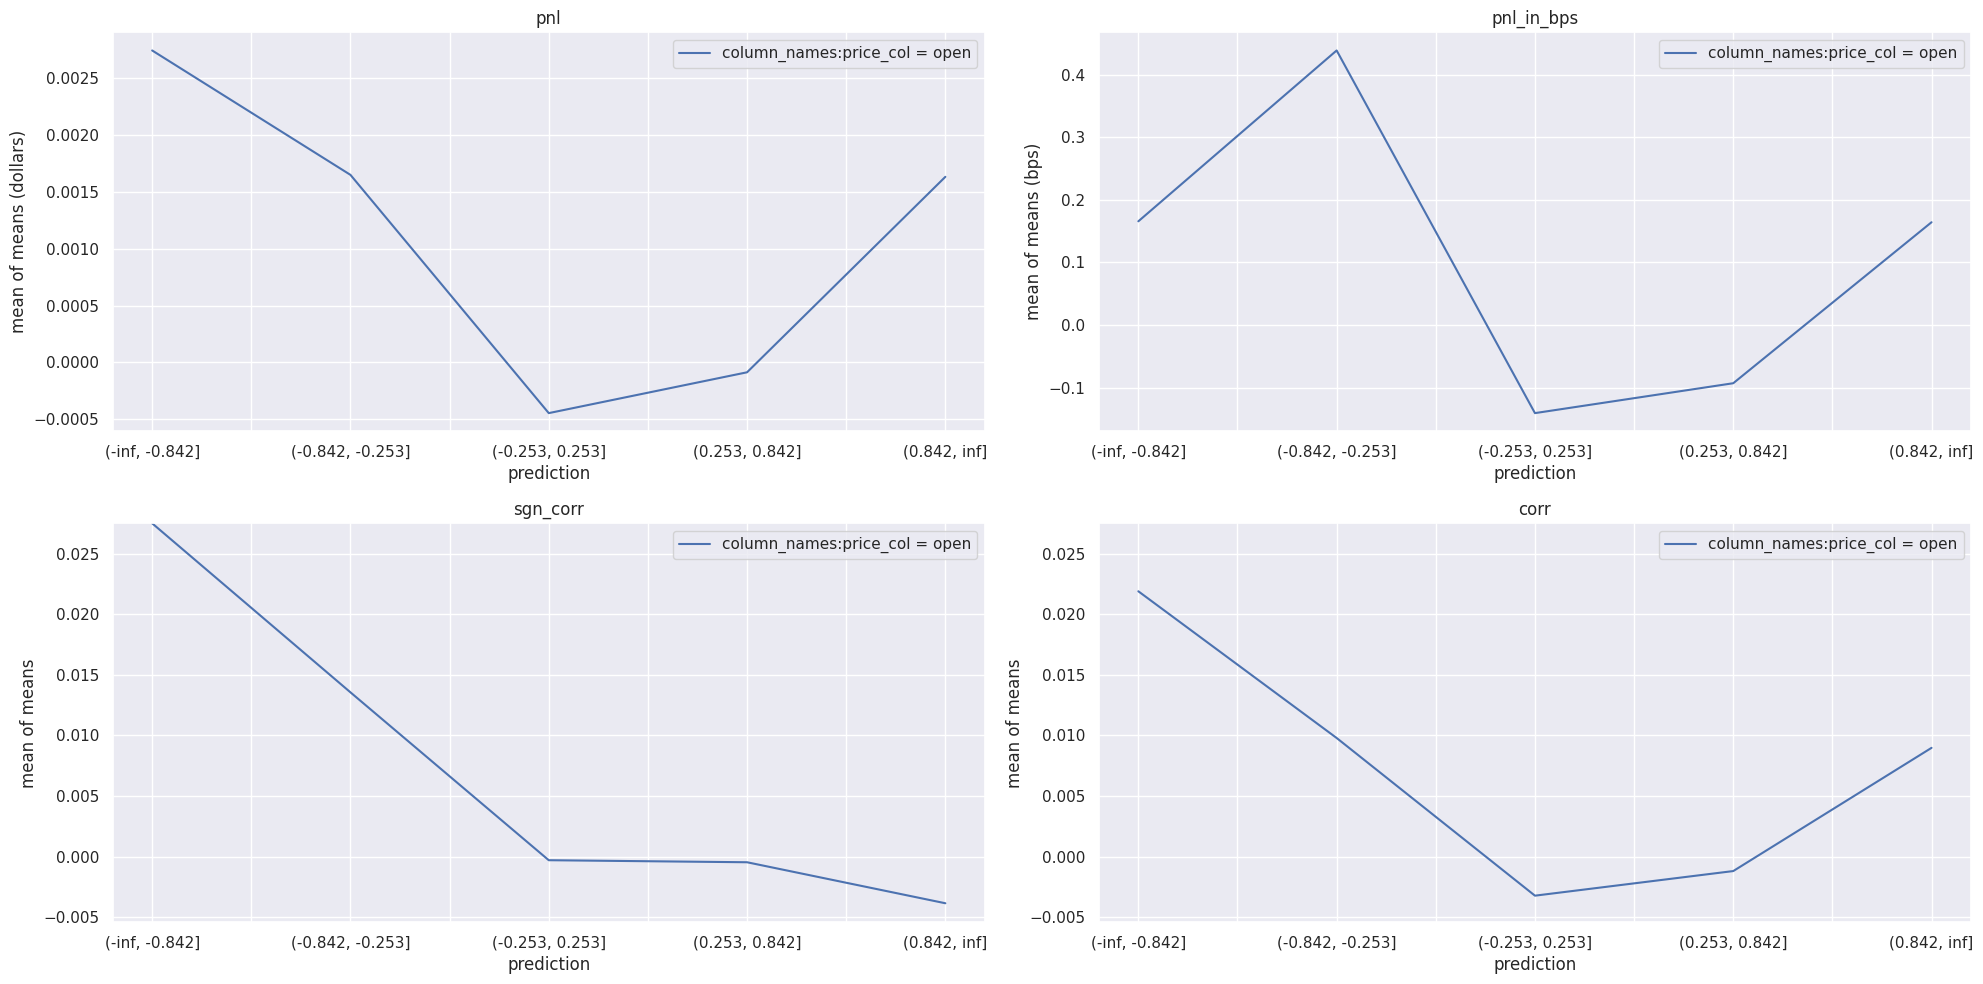

In [43]:
coplotti.plot_portfolio_binned_stats(
    portfolio_df_dict,
    **config["bin_annotated_portfolio_df_kwargs"],
)

# Compute aggregate portfolio stats

In [44]:
stats_computer = dtfmod.StatsComputer()

In [45]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    portfolio_stats_df_timestamped,
    default_config["pnl_resampling_frequency"],
)
display(portfolio_stats)

ratios      sharpe_ratio                     11.89
            sharpe_ratio_standard_error       3.50
            sr.tval                           3.41
            sr.pval                           0.00
            kratio                           11.43
dollar      gmv_mean                        984.71
            gmv_stdev                       121.19
            annualized_mean_return         2654.44
            annualized_volatility           223.27
            max_drawdown                     42.09
            pnl_mean                          0.30
            pnl_std                           2.39
            turnover_mean                  8916.76
            turnover_stdev                 2643.63
            market_bias_mean                 20.00
            market_bias_stdev                53.41
percentage  annualized_mean_return          269.57
            annualized_volatility            22.67
            max_drawdown                      4.27
            pnl_mean           